#### Measuring No-Index Query Execution Time on TCP-H (OLAP) Benchmark

For the TPC-H 1GB database, we will now run batches of queries, i.e. small workloads, and measure the query execution time per workload. 


In [2]:
import pyodbc
import sys
import random
import pandas as pd
import time
import os
from tqdm import tqdm
import logging
import re
import xml.etree.ElementTree as ET


#### Read all the generated sample queries and store them in a list.

In [3]:
def read_sql_files(base_dir, instances_per_template):
    queries = []
    
    # Regex to find erroneous "where rownum <=" lines
    erroneous_line_pattern = re.compile(r'^\s*where\s+rownum\s*<=\s*\d+\s*;\s*$', re.IGNORECASE)

    # Loop through each query directory
    for query_dir in sorted(os.listdir(base_dir)):
        query_path = os.path.join(base_dir, query_dir)
        
        if os.path.isdir(query_path):
            # Initialize a counter for the number of instances read from this template
            instance_count = 0
            
            # Loop through each SQL file in the query directory
            for sql_file in sorted(os.listdir(query_path)):
                if instance_count >= instances_per_template:
                    break  # Stop reading more files from this template
                
                sql_file_path = os.path.join(query_path, sql_file)
                
                if sql_file_path.endswith('.sql'):
                    with open(sql_file_path, 'r') as file:
                        lines = file.readlines()
                        
                        # Filter out the erroneous "where rownum <=" lines
                        filtered_lines = [line for line in lines if not erroneous_line_pattern.match(line)]
                        
                        # Extract the query from the filtered lines
                        query = ''.join(filtered_lines[3:]).strip()
                        
                        queries.append(query)
                        instance_count += 1  # Increment the counter
    
    return queries


# Base directory containing the generated queries
base_dir = './TPCH_generated_queries'

# Read the SQL files and store the queries in a list
queries = read_sql_files(base_dir, instances_per_template=20)

print(len(queries))

440


In [10]:
conn_str = (
    "Driver={ODBC Driver 17 for SQL Server};"
    "Server=172.16.6.196,1433;"  # Use the IP address and port directly
    "Database=TPCH1;"  
    "UID=wsl;" 
    "PWD=greatpond501;"  
)

conn = pyodbc.connect(conn_str)
cursor = conn.cursor()
# test the connection
print(cursor.execute("SELECT @@version;"))


# simple query execution
def execute_query_simple(query, connection):
    cursor = connection.cursor()
    try:
        start_time = time.time()
        cursor.execute(query)
        connection.commit()
        end_time = time.time()
        cost = end_time - start_time
        return True, cost
    except Exception as e:
        print(f"Error executing query: {e}")
        return False, None
    finally:
        cursor.close()


""" Code originally from Malinga Perera's work """
class QueryPlan:
    def __init__(self, xml_string):
        self.estimated_rows = 0
        self.est_statement_sub_tree_cost = 0
        self.elapsed_time = 0
        self.cpu_time = 0
        self.non_clustered_index_usage = []
        self.clustered_index_usage = []

        ns = {'sp': 'http://schemas.microsoft.com/sqlserver/2004/07/showplan'}
        root = ET.fromstring(xml_string)
        stmt_simple = root.find('.//sp:StmtSimple', ns)
        if stmt_simple is not None:
            self.estimated_rows = float(stmt_simple.attrib.get('StatementEstRows', 0))
            self.est_statement_sub_tree_cost = float(stmt_simple.attrib.get('StatementSubTreeCost', 0))

        query_stats = root.find('.//sp:QueryTimeStats', ns)
        if query_stats is not None:
            self.cpu_time = float(query_stats.attrib.get('CpuTime', 0))
            self.elapsed_time = float(query_stats.attrib.get('ElapsedTime', 0)) / 1000

        rel_ops = root.findall('.//sp:RelOp', ns)
        total_po_sub_tree_cost = 0
        total_po_actual = 0

        for rel_op in rel_ops:
            temp_act_elapsed_time = 0
            if rel_op.attrib.get('PhysicalOp') in {'Index Seek', 'Index Scan', 'Clustered Index Scan', 'Clustered Index Seek'}:
                total_po_sub_tree_cost += float(rel_op.attrib.get('EstimatedTotalSubtreeCost', 0))
                runtime_thread_information = rel_op.findall('.//sp:RunTimeCountersPerThread', ns)
                for thread_info in runtime_thread_information:
                    temp_act_elapsed_time = max(
                        int(thread_info.attrib.get('ActualElapsedms', 0)), temp_act_elapsed_time)
                total_po_actual += temp_act_elapsed_time / 1000

        for rel_op in rel_ops:
            rows_read = 0
            act_rel_op_elapsed_time = 0
            if rel_op.attrib.get('PhysicalOp') in {'Index Seek', 'Index Scan', 'Clustered Index Scan', 'Clustered Index Seek'}:
                runtime_thread_information = rel_op.findall('.//sp:RunTimeCountersPerThread', ns)
                for thread_info in runtime_thread_information:
                    rows_read += int(thread_info.attrib.get('ActualRowsRead', 0))
                    act_rel_op_elapsed_time = max(int(thread_info.attrib.get('ActualElapsedms', 0)), act_rel_op_elapsed_time)
            act_rel_op_elapsed_time = act_rel_op_elapsed_time / 1000
            if rows_read == 0:
                rows_read = float(rel_op.attrib.get('EstimatedRowsRead', 0))
            rows_output = float(rel_op.attrib.get('EstimateRows', 0))
            if rel_op.attrib.get('PhysicalOp') in {'Index Seek', 'Index Scan'}:
                po_index_scan = rel_op.find('.//sp:IndexScan', ns)
                if po_index_scan is not None:
                    po_index = po_index_scan.find('.//sp:Object', ns).attrib.get('Index', '').strip("[]")
                    self.non_clustered_index_usage.append(
                        (po_index, act_rel_op_elapsed_time, self.cpu_time, self.est_statement_sub_tree_cost, rows_read, rows_output))
            elif rel_op.attrib.get('PhysicalOp') in {'Clustered Index Scan', 'Clustered Index Seek'}:
                po_index_scan = rel_op.find('.//sp:IndexScan', ns)
                if po_index_scan is not None:
                    table = po_index_scan.find('.//sp:Object', ns).attrib.get('Table', '').strip("[]")
                    self.clustered_index_usage.append(
                        (table, act_rel_op_elapsed_time, self.cpu_time, self.est_statement_sub_tree_cost, rows_read, rows_output))
                    

# more sophisticated query execution metrics        
def execute_query(query, connection, cost_type='elapsed_time', verbose=False):
    try:
        cursor = connection.cursor()
        # clear cache
        cursor.execute("DBCC DROPCLEANBUFFERS")
        # enable statistics collection
        cursor.execute("SET STATISTICS XML ON")
        # execute the query
        cursor.execute(query)
        cursor.nextset()
        # fetch execution stats
        stat_xml = cursor.fetchone()[0]
        cursor.execute("SET STATISTICS XML OFF")
        # parse query plan
        query_plan = QueryPlan(stat_xml)

        if verbose:
            print(f"QUERY: \n{query}\n")
            print(f"ELAPSED TIME: \n{query_plan.elapsed_time}\n")
            print(f"CPU TIME: \n{query_plan.cpu_time}\n")
            print(f"SUBTREE COST: \n{query_plan.est_statement_sub_tree_cost}\n")
            print(f"NON CLUSTERED INDEX USAGE: \n{query_plan.non_clustered_index_usage}\n")
            print(f"CLUSTERED INDEX USAGE: \n{query_plan.clustered_index_usage}\n")

        # Determine the cost type and return the appropriate metric
        if cost_type == 'elapsed_time':
            return float(query_plan.elapsed_time), query_plan.non_clustered_index_usage, query_plan.clustered_index_usage
        elif cost_type == 'cpu_time':
            return float(query_plan.cpu_time), query_plan.non_clustered_index_usage, query_plan.clustered_index_usage
        elif cost_type == 'sub_tree_cost':
            return float(query_plan.est_statement_sub_tree_cost), query_plan.non_clustered_index_usage, query_plan.clustered_index_usage
        else:
            return float(query_plan.est_statement_sub_tree_cost), query_plan.non_clustered_index_usage, query_plan.clustered_index_usage
    except Exception as e:
        logging.error(f"Exception when executing query: {query}, Error: {e}")
        return-1, [], []
    finally:
        cursor.close()


def execute_workload(workload):
    # Establish a connection to the database
    conn = pyodbc.connect(conn_str)
    cursor = conn.cursor()
    elapsed_time = 0
    # execute the workload
    for i, query in enumerate(workload):
        cost, index_seeks, clustered_index_scans = execute_query(query, conn)
        elapsed_time += cost    
        if cost == -1:
            print(f"Error executing query # {i} in current workload")

    cursor.close()
    conn.close()
    return elapsed_time

In [11]:
conn = pyodbc.connect(conn_str)
execute_query(queries[0], conn, verbose=True)
conn.close()

QUERY: 
select
	l_returnflag,
	l_linestatus,
	sum(l_quantity) as sum_qty,
	sum(l_extendedprice) as sum_base_price,
	sum(l_extendedprice * (1 - l_discount)) as sum_disc_price,
	sum(l_extendedprice * (1 - l_discount) * (1 + l_tax)) as sum_charge,
	avg(l_quantity) as avg_qty,
	avg(l_extendedprice) as avg_price,
	avg(l_discount) as avg_disc,
	count(*) as count_order
from
	lineitem
where
	l_shipdate <= DATEADD(dd, -108, CAST('1998-12-01' AS date))
group by
	l_returnflag,
	l_linestatus
order by
	l_returnflag,
	l_linestatus;

ELAPSED TIME: 
13.326

CPU TIME: 
13312.0

SUBTREE COST: 
126.67

NON CLUSTERED INDEX USAGE: 
[]

CLUSTERED INDEX USAGE: 
[('lineitem', 2.325, 13312.0, 126.67, 6001215, 5885680.0)]



In [5]:
# shuffle the queries list
random.shuffle(queries)

batch_size = 10

# now run the queries in batches and get execution times
workload_times = []
for i in tqdm(range(0, len(queries), batch_size), desc="Executing Batches"):
    batch = queries[i:i+batch_size]
    elapsed_time = execute_workload(batch)
    workload_times.append(elapsed_time)


Executing Batches:  43%|████▎     | 19/44 [05:45<06:15, 15.02s/it]

Error executing query: <class 'pyodbc.Error'> returned a result with an exception set
Error executing query # 8 in current workload
Error executing query: ('08S01', '[08S01] [Microsoft][ODBC Driver 17 for SQL Server]Communication link failure (0) (SQLExecDirectW)')
Error executing query # 9 in current workload


Text(0, 0.5, 'Execution Time (s)')

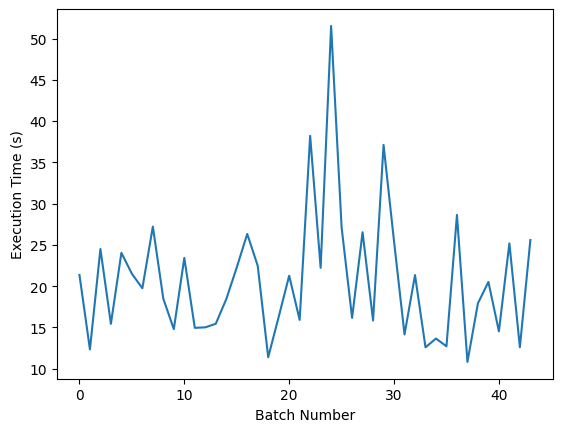

In [7]:
workload_times

# plot the execution times
import matplotlib.pyplot as plt

plt.plot(workload_times)
plt.xlabel("Batch Number")
plt.ylabel("Execution Time (s)")

In [24]:
i = 15
print(queries[i])
print(f"\nQuery execution time: {execute_queries(queries[i:i+1]):.2f} seconds")

select
	n_name,
	sum(l_extendedprice * (1 - l_discount)) as revenue
from
	customer,
	orders,
	lineitem,
	supplier,
	nation,
	region
where
	c_custkey = o_custkey
	and l_orderkey = o_orderkey
	and l_suppkey = s_suppkey
	and c_nationkey = s_nationkey
	and s_nationkey = n_nationkey
	and n_regionkey = r_regionkey
	and r_name = 'EUROPE'
	and o_orderdate >= CAST('1994-01-01' AS date)
	and o_orderdate < DATEADD(yy, 1, CAST('1994-01-01' AS date))
group by
	n_name
order by
	revenue desc;

Query execution time: 1.48 seconds
